Корпоратив
Все мы часто задаемся вопросом, где нам покушать? Предположим Вы подчиненный владельца крупной компании с (кхм)жёлтым приложением. Ваш босс хочет провести корпоратив для всего технического отдела. Он предложил Вам провести исследование, где лучше всего расположиться Вашей большой командой. Рассчитывайте, что Вас не менее 350 человек. Бюджет не ограничен. Подберите место, которое по расположению ближе всего к Красной площади и при этом вмещает нужное кол-во человек. При этом он не хочет праздновать в какой-то там столовой.
Для решения задачи постройте карту, нанесите на неё заведения, удовлетворяющие пожеланиям босса. В конце проведите некоторый анализ и приведите аргументы, почему Вы выбрали то или иное заведение.
В анализ входит:
 1. Показать вероятность того, что если босс случайно выберет заведение из списка, удовлетворяющего условию, оно окажется рестораном. Сравните эту вероятность с другими видами объектов
 2. Определите топ 30 ресторанов Москвы по расположению, считаем, если мы близко к центру, то это заведение круче, чем остальные

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import folium

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

#### 1. Подготовка данных

Загрузим данные о точках питания с помощью `pandas`.

In [2]:
pb_train = pd.read_xml('data/data.xml', encoding='windows-1251')
print('Размер выборки:', pb_train.shape)

Размер выборки: (20719, 16)


Посмотрим на вид, в котором хранятся данные.

In [3]:
pb_train.iloc[:10]

,Address,Latitude_WGS84,global_id,TypeObject,geoData,geodata_center,Longitude_WGS84,Name,IsNetObject,AdmArea,OperatingCompany,PublicPhone,SeatsCount,ID,District,SocialPrivileges
0,"Российская Федерация, город Москва, внутригоро...",55.879002,637376221,кафе,NaN,NaN,37.714565,СМЕТАНА,нет,Северо-Восточный административный округ,None,NaN,48,151635,Ярославский район,нет
1,"город Москва, улица Талалихина, дом 2/1, корпус 1",55.738239,637376331,кафе,NaN,NaN,37.673306,Родник,нет,Центральный административный округ,None,NaN,35,77874,Таганский район,нет
2,"Российская Федерация, город Москва, внутригоро...",55.735511,637376349,ресторан,NaN,NaN,37.669648,Кафе «Академия»,нет,Центральный административный округ,None,NaN,95,24309,Таганский район,нет
3,"город Москва, Угличская улица, дом 17",55.904019,637376480,столовая,NaN,NaN,37.566940,ГБОУ «Школа № 1430 имени Героя Социалистическо...,нет,Северо-Восточный административный округ,None,NaN,240,27429,район Лианозово,нет
4,"город Москва, переулок Сивцев Вражек, дом 6/2",55.747390,637376481,кафе,NaN,NaN,37.598128,Брусника,да,Центральный административный округ,Брусника,NaN,10,148815,район Арбат,нет
5,"город Москва, Авиамоторная улица, дом 8, строе...",55.755164,637376500,столовая,NaN,NaN,37.715425,Буфет МТУСИ,нет,Юго-Восточный административный округ,None,NaN,90,20957,район Лефортово,нет
6,"город Москва, Авиамоторная улица, дом 8, строе...",55.755164,637376536,столовая,NaN,NaN,37.715425,Столовая МТУСИ,нет,Юго-Восточный административный округ,None,NaN,120,28858,район Лефортово,нет
7,"город Москва, Авиамоторная улица, дом 49/1",55.749276,637376678,кафе,NaN,NaN,37.719950,Кафе Гогиели,нет,Юго-Восточный административный округ,None,NaN,24,23394,район Лефортово,нет
8,"Российская Федерация, город Москва, внутригоро...",55.645103,637376719,кафе,NaN,NaN,37.398531,Алло Пицца,да,Западный административный округ,Алло Пицца,NaN,32,22579,район Солнцево,нет
9,"город Москва, улица Щорса, дом 6, корпус 1",55.646396,637376788,столовая,NaN,NaN,37.401576,ГБОУ ШКОЛА 1542,нет,Западный административный округ,None,NaN,60,23670,район Солнцево,нет


Выведем карту Москвы с помощью `folium`.

In [4]:
moscow_map = folium.Map(location=[55.75, 37.62], zoom_start=12)

Заведем массив для хранения типов заведений.

In [5]:
point_types = pb_train['TypeObject'].unique()
point_types

array(['кафе', 'ресторан', 'столовая',
       'предприятие быстрого обслуживания', 'бар', 'кафетерий', 'буфет',
       'закусочная', 'магазин (отдел кулинарии)'], dtype=object)

Исключим из рассмотрения магазины

In [6]:
point_types = point_types[point_types != 'магазин (отдел кулинарии)']
pb_train = pb_train[pb_train['TypeObject'] != 'магазин (отдел кулинарии)']

Присвоим цвета каждому типу заведения. (Отобразим это в легенде)

In [7]:
point_colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
                'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
                'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
                'gray', 'black', 'lightgray']

points_colors = dict(zip(point_types, point_colors))
points_colors

{'кафе': 'red',
 'ресторан': 'blue',
 'столовая': 'green',
 'предприятие быстрого обслуживания': 'purple',
 'бар': 'orange',
 'кафетерий': 'darkred',
 'буфет': 'lightred',
 'закусочная': 'beige'}

Отфильтруем выборку, оставив только рестораны, в которых больше 350 мест.

In [8]:
pb_train_th = pb_train[(pb_train['SeatsCount'] > 350) & (pb_train['TypeObject'] == 'ресторан')]

print('Размер выборки:', pb_train_th.shape)

Размер выборки: (39, 16)


Выведем на карту с отфильтрованными заведениями.

In [9]:
for index, row in pb_train_th.iterrows():
    folium.CircleMarker(
        location=(row['Latitude_WGS84'], row['Longitude_WGS84'],),
        radius=5,
        color=points_colors[row['TypeObject']],
        fill=True,
        fill_color=points_colors[row['TypeObject']],
        fill_opacity=0.7,
        popup=row['Name'],
        tooltip=row['TypeObject']
    ).add_to(moscow_map)

Отметим на карте Кремль.

In [10]:
kremlin_coords = (55.751666666694774221, 37.61777777780577736,)

folium.CircleMarker(
    location=kremlin_coords,
    radius=10,
    color='black',
    fill=True,
    fill_color='black',
    fill_opacity=0.7,
    popup='Kremlin',
    tooltip='Kremlin'
).add_to(moscow_map)

moscow_map

Вычислим расстояние от каждого ресторана до Кремля и построим гистограмму распределения.

/var/folders/42/r_n219px5bgcpzqd6fx4z8g40000gn/T/ipykernel_3715/484017111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pb_train_th['distance_to_kremlin'] = pb_train_th.apply(lambda row: geodesic(kremlin_coords, (row['Latitude_WGS84'], row['Longitude_WGS84'])).km, axis=1)
/var/folders/42/r_n219px5bgcpzqd6fx4z8g40000gn/T/ipykernel_3715/484017111.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

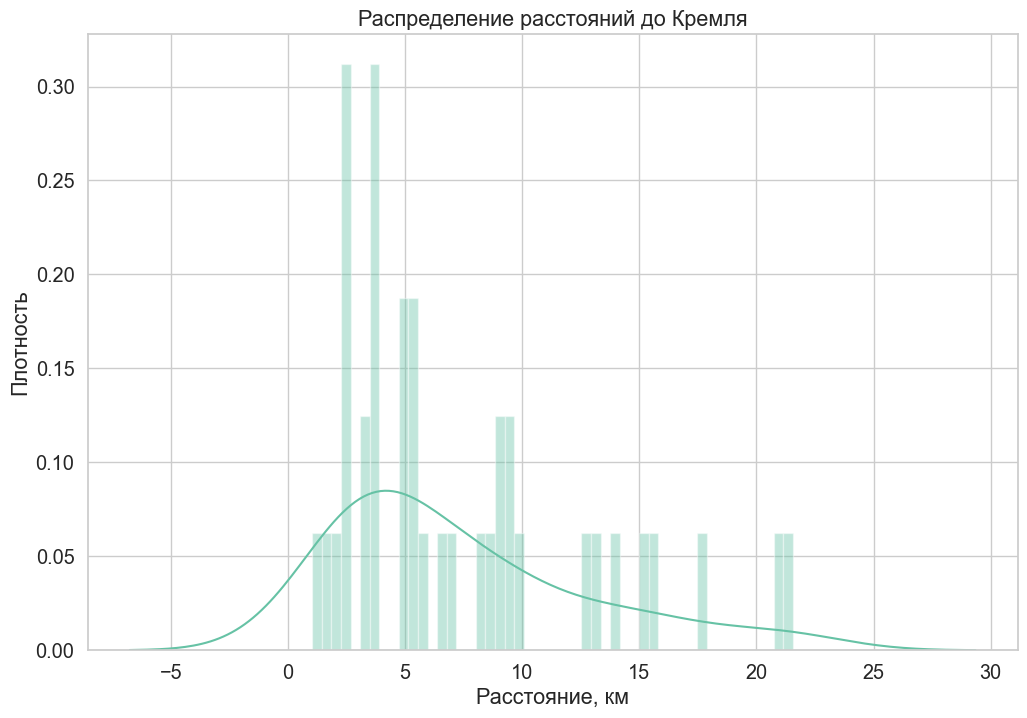

In [11]:
pb_train_th['distance_to_kremlin'] = pb_train_th.apply(lambda row: geodesic(kremlin_coords, (row['Latitude_WGS84'], row['Longitude_WGS84'])).km, axis=1)

plt.figure(figsize=(12, 8))
sns.distplot(pb_train_th['distance_to_kremlin'], bins=50)
plt.title('Распределение расстояний до Кремля')
plt.xlabel('Расстояние, км')
plt.ylabel('Плотность')
plt.show()

Выведем топ 30 ресторанов по расстоянию до Кремля.

In [12]:
top_30 = pb_train_th.sort_values(by='distance_to_kremlin', ascending=True).head(30)
top_30_bw = top_30[['Name', 'SeatsCount', 'distance_to_kremlin']]
top_30_bw

,Name,SeatsCount,distance_to_kremlin
2462,Грабли,400,1.034263
1974,Чайхона №1,500,1.750602
4236,Диско 90-х,400,1.884344
1694,Чайхона №1,430,2.353573
16328,Ресторан «ЧеХарчо»,378,2.385636
8975,Ресторан «Сыроварня»,378,2.393720
14854,ФАУЛЗ,472,2.624358
1048,Paulaner Brauhaus,500,2.642452
2541,РУМ СЕРВИС,1200,3.270838
2026,РУМ СЕРВИС,1200,3.399666


Обведем их на карте в желтый цвет.

In [13]:
pl_counter = 0
for index, row in top_30.iterrows():
    pl_counter += 1
    folium.CircleMarker(
        location=(row['Latitude_WGS84'], row['Longitude_WGS84'],),
        radius=5,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        popup="{} место. {}".format(str(pl_counter), row['Name']),
        tooltip="{} место.".format(str(pl_counter)),
    ).add_to(moscow_map)

Также определим ближайший к Кремлю ресторан, вмещающий не менее 350 человек.

In [14]:
nearest = pb_train_th.sort_values(by='distance_to_kremlin', ascending=True).head(1)
nearest_bw = nearest[['Name', 'SeatsCount', 'distance_to_kremlin']]
nearest_bw

,Name,SeatsCount,distance_to_kremlin
2462,Грабли,400,1.034263


Добавим его на карту золотым цветом.

In [15]:
for index, row in nearest.iterrows():
    folium.CircleMarker(
        location=(row['Latitude_WGS84'], row['Longitude_WGS84'],),
        radius=7,
        color='gold',
        fill=True,
        fill_color='gold',
        fill_opacity=0.7,
        popup="Лучший подходящий ресторан: {}".format(row['Name']),
        tooltip="Лучший ресторан"
    ).add_to(moscow_map)

Посмотрим на финальную карту!

In [16]:
moscow_map

# Найдем вероятность того, что случайное выбранное боссом заведение окажется рестораном.

In [17]:
pb_train_rest = pb_train[pb_train['TypeObject'] == 'ресторан']
print('Доля ресторанов: ', pb_train_rest.shape[0] / pb_train.shape[0])

Доля ресторанов:  0.11892722585762443
